In [1]:
# import required libraries and packages

import os, sys, random, warnings
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.utils import load_img, img_to_array

import tensorflow as tf

2023-02-05 17:28:35.128862: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


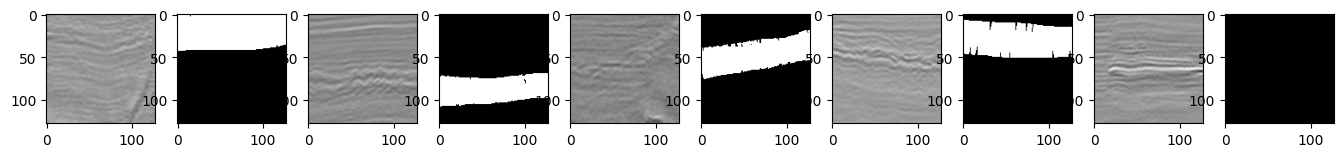

In [2]:
# Display some example image and mask patches

ids= ['0e4l9s4bq7i2vwkfbn31','9vy3d26lfsgbrsiakipm','qemqd2nzuc1eogvpjrak','oikz1pvnz14vs00an5ym','t0w0035l5odb17ttq833']

plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('./train/images/' + img_name + '.png')
    img_mask = load_img('./train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()


#white patches indicate chaotic facies region in the image

In [3]:
path_train = './train/'   # path to train images and masks
path_test = './test/'     # path to test images

train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [4]:
len(train_ids), len(test_ids)

(330, 65)

In [5]:
im_height = 128    # new height
im_width = 128    # new width
im_chan = 1     # number of image channel

In [6]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)

/tmp/ipykernel_235989/2189733536.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)


In [7]:
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)

/tmp/ipykernel_235989/2189733536.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)


In [10]:
path = path_train
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + '/masks/' + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

print('Done!')

/tmp/ipykernel_235989/429381188.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/330 [00:00<?, ?it/s]

Done!


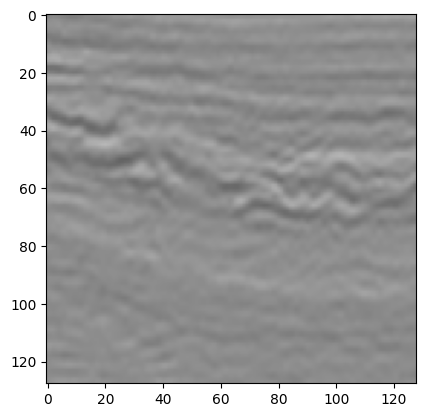

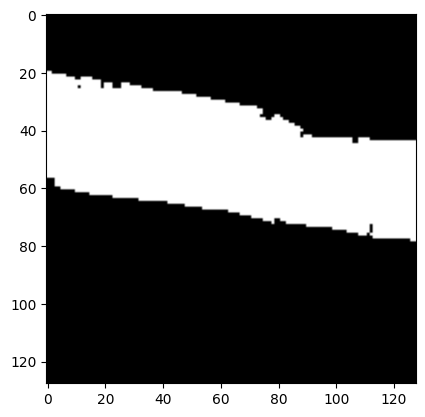

In [11]:
# Quakity check to see if training data looks all right

ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

In [12]:
# creating empty test image arrays

X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)

In [13]:
path = path_test
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    
    img = load_img(path + '/images/' + id_)
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode='constant', preserve_range=True)
    X_test[n] = x

print('Done!')

/tmp/ipykernel_235989/2333299189.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):


  0%|          | 0/65 [00:00<?, ?it/s]

Done!


In [14]:
X_train.shape, X_test.shape, Y_train.shape

((330, 128, 128, 1), (65, 128, 128, 1), (330, 128, 128, 1))

In [46]:
# Build U-Net model
inputs = Input((im_height, im_width, im_chan))
s = Lambda(lambda x: x / 255) (inputs)


# CONTRASTIVE and ENCODING PART
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

# EXPANSIVE and DECODING PART
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

# OUTPUT LAYER
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])


In [47]:
earlystopper = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint('OOD-chaotic-facies-model.h5', verbose=1, save_best_only=True)
epochs = 50
batch_size = 8
validation_size = 0.2

In [48]:
results = model.fit(X_train, Y_train, validation_split=validation_size, 
                    batch_size=batch_size, epochs=epochs, callbacks=[earlystopper, checkpointer])

Epoch 1/50
30/33 [==========================>...] - ETA: 0s - loss: 0.4110 - accuracy: 0.8917
Epoch 1: val_loss improved from inf to 0.18165, saving model to OOD-chaotic-facies-model.h5
33/33 [==============================] - 2s 27ms/step - loss: 0.3918 - accuracy: 0.8974 - val_loss: 0.1817 - val_accuracy: 0.9610
Epoch 2/50
31/33 [===========================>..] - ETA: 0s - loss: 0.2440 - accuracy: 0.9356
Epoch 2: val_loss improved from 0.18165 to 0.16361, saving model to OOD-chaotic-facies-model.h5
33/33 [==============================] - 1s 16ms/step - loss: 0.2423 - accuracy: 0.9363 - val_loss: 0.1636 - val_accuracy: 0.9610
Epoch 3/50
29/33 [=========================>....] - ETA: 0s - loss: 0.2365 - accuracy: 0.9349
Epoch 3: val_loss improved from 0.16361 to 0.16126, saving model to OOD-chaotic-facies-model.h5
33/33 [==============================] - 1s 17ms/step - loss: 0.2324 - accuracy: 0.9363 - val_loss: 0.1613 - val_accuracy: 0.9610
Epoch 4/50
31/33 [==========================

In [49]:
# Predict on train, val and test
model = load_model('OOD-chaotic-facies-model.h5')
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.8)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.8):], verbose=1)

preds_test = model.predict(X_test, verbose=1)    # test data

3/3 [==============================] - 0s 10ms/step


In [50]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

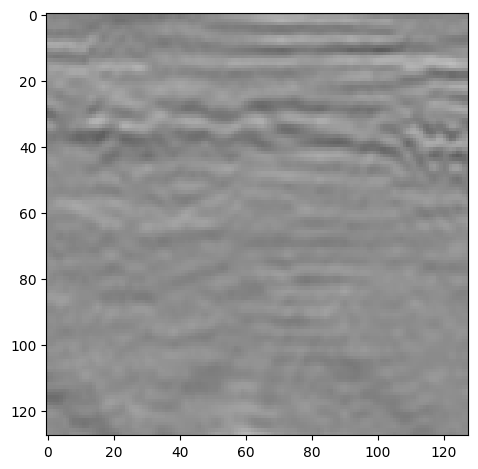

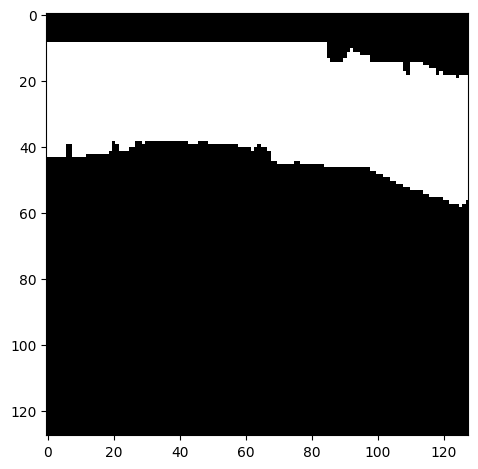

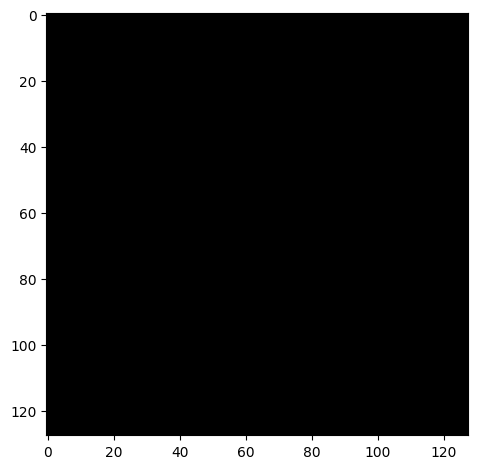

In [59]:
# Train samples predicted

ix = random.randint(0, len(preds_train_t))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

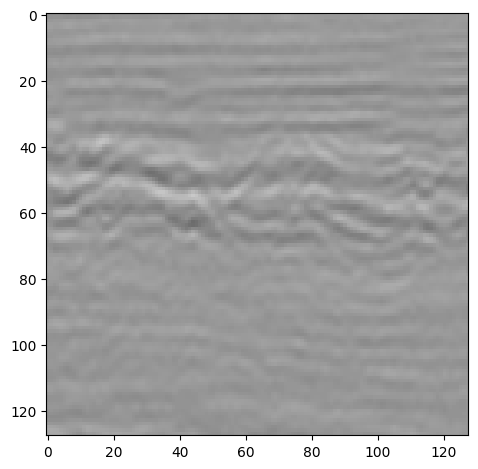

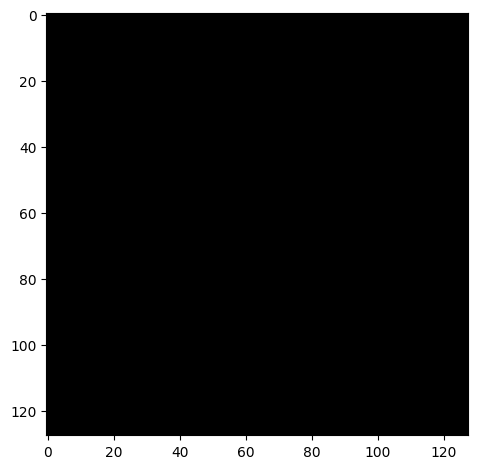

In [64]:
# Test samples predicted

ix = random.randint(0, len(preds_test_t))
imshow(np.squeeze(X_test[ix]))
plt.show()
tmp = np.squeeze(preds_test_t[ix]).astype(np.float32)
imshow(np.dstack((tmp,tmp,tmp)))
plt.show()